# Detecting Sign Language with OpenPose

This notebook uses an open source project [CMU-Perceptual-Computing-Lab/openpose](https://github.com/CMU-Perceptual-Computing-Lab/openpose.git) to detect sign language poses including the boday, the face, and the hand gestures.

The code for the following notebook is modified based on [tugstugi/dl-colab-notebooks](https://github.com/tugstugi/dl-colab-notebooks).

## Install OpenPose

In [ ]:
import os
from os.path import exists, join, basename, splitext

git_repo_url = 'https://github.com/CMU-Perceptual-Computing-Lab/openpose.git'
project_name = splitext(basename(git_repo_url))[0]
if not exists(project_name):
  # see: https://github.com/CMU-Perceptual-Computing-Lab/openpose/issues/949
  # install new CMake becaue of CUDA10
  !wget -q https://cmake.org/files/v3.13/cmake-3.13.0-Linux-x86_64.tar.gz
  !tar xfz cmake-3.13.0-Linux-x86_64.tar.gz --strip-components=1 -C /usr/local
  # clone openpose
  !git clone -q --depth 1 $git_repo_url
  !sed -i 's/execute_process(COMMAND git checkout master WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/execute_process(COMMAND git checkout f019d0dfe86f49d1140961f8c7dec22130c83154 WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/g' openpose/CMakeLists.txt
  # install system dependencies
  !apt-get -qq install -y libatlas-base-dev libprotobuf-dev libleveldb-dev libsnappy-dev libhdf5-serial-dev protobuf-compiler libgflags-dev libgoogle-glog-dev liblmdb-dev opencl-headers ocl-icd-opencl-dev libviennacl-dev
  # install python dependencies
  !pip install -q youtube-dl
  # build openpose
  !cd openpose && rm -rf build || true && mkdir build && cd build && cmake .. && make -j`nproc`

from IPython.display import YouTubeVideo

Selecting previously unselected package liblmdb0:amd64.
(Reading database ... 123597 files and directories currently installed.)
Preparing to unpack .../00-liblmdb0_0.9.24-1build2_amd64.deb ...
Unpacking liblmdb0:amd64 (0.9.24-1build2) ...
Selecting previously unselected package libgflags2.2.
Preparing to unpack .../01-libgflags2.2_2.2.2-2_amd64.deb ...
Unpacking libgflags2.2 (2.2.2-2) ...
Selecting previously unselected package libgflags-dev.
Preparing to unpack .../02-libgflags-dev_2.2.2-2_amd64.deb ...
Unpacking libgflags-dev (2.2.2-2) ...
Selecting previously unselected package libgoogle-glog0v5.
Preparing to unpack .../03-libgoogle-glog0v5_0.5.0+really0.4.0-2_amd64.deb ...
Unpacking libgoogle-glog0v5 (0.5.0+really0.4.0-2) ...
Selecting previously unselected package libunwind-dev:amd64.
Preparing to unpack .../04-libunwind-dev_1.3.2-2build2.1_amd64.deb ...
Unpacking libunwind-dev:amd64 (1.3.2-2build2.1) ...
Selecting previously unselected package libgoogle-glog-dev.
Preparing to un

## Download a sample Korean sign language video

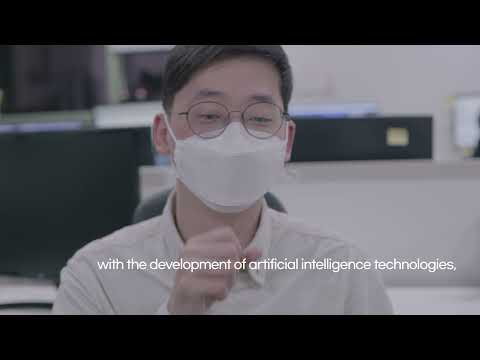

In [ ]:
KSL_ID = 'VjainPzPo2k'
YouTubeVideo(KSL_ID)

After downloading the video, process it through openpose.
By default CMU openpose does not annotate face and hand poses. To include them, add '--hand --face' as shown below:

`./build/examples/openpose/openpose.bin --face --hand --video ../video.mp4 --write_json ./output/ --display 0  --write_video ../openpose.avi`

For details on how to use openpose, refer to the [openpose github](https://github.com/CMU-Perceptual-Computing-Lab/openpose#quick-start-overview)

The output is in *.avi format so convert it into *.mp4 for easy processing. The conversion can be done through ffmpeg.

Two outputs are specified.
- --write_json: write the auto-annotation results to a json file. For each frame of the video, one json file will be generated.
- --write_video: writes a video that includes the pose annotations

In [ ]:
def download_youtube(youtube_id, start_time=10, duration=5):
  !rm -rf clip*.mp4
  !rm -rf openpose/output/*
  # # download the youtube with the given ID
  !youtube-dl -f 'bestvideo[ext=mp4]' --output "youtube.%(ext)s" https://www.youtube.com/watch?v=$youtube_id
  # just pick a section where sign language is done
  !ffmpeg -y -loglevel info -ss $start_time -t $duration -i youtube.mp4 clip.mp4
  # # detect poses on the these 10 seconds
  !rm openpose.avi
  !cd openpose && ./build/examples/openpose/openpose.bin --face --hand --video ../clip.mp4 --write_json ./output_json/ --display 0  --write_video ../clip_openpose.avi
  # convert the result into MP4
  !ffmpeg -y -loglevel info -i clip_openpose.avi clip_openpose.mp4

download_youtube(KSL_ID)

[youtube] VjainPzPo2k: Downloading webpage
ERROR: Unable to extract uploader id; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.
ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libop

Download the above youtube video, cut the first 10 seconds and do the pose detection on that 10 seconds:

Finally, visualize the result:

## Visualize the result

### video
Openpose outputs a video file that contains superimposed keypoint annotations. Let's first see how we can visualize it.

In [ ]:
def show_local_mp4_video(file_name, width=640, height=480):
  import io
  import base64
  from IPython.display import HTML
  video_encoded = base64.b64encode(io.open(file_name, 'rb').read())
  return HTML(data='''<video width="{0}" height="{1}" alt="test" controls>
                        <source src="data:video/mp4;base64,{2}" type="video/mp4" />
                      </video>'''.format(width, height, video_encoded.decode('ascii')))

show_local_mp4_video('clip_openpose.mp4', width=960, height=720)

FileNotFoundError: ignored

### images
Under the hood, openpose splits the video into individual frames and auto-annotate each image. To see the detailed output, we can use ffmpeg to see how the video is split into different frame images.

The command to do that is:

`-vf fps=30`

To make the output filenames easy to trace, let's format the numbered output file names by padding them with five zeroes.
`./images/out%05.png`

## Convert the video into frame images

In [ ]:
!rm openpose/images/video_out*.png
!mkdir openpose/output_images/
!cd openpose && ffmpeg -ss 10 -t 5 -i ../youtube.mp4 ./output_images/out%05d.png -vf fps=30

rm: cannot remove 'openpose/images/video_out*.png': No such file or directory
ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --e

# Visualize key points on images

In [ ]:
import cv2
import glob
import json
import numpy as np
import os

from matplotlib import pyplot as plt

def load_images(path):
    path = os.path.join(path,'*')
    files = glob.glob(path)
    # We sort the images in alphabetical order to match them
    #  to the annotation files
    files.sort()

    X_raw = []
    for file in files:
        image = cv2.imread(file)
        X_raw.append(np.array(image))

    return X_raw

def from_json(path):
    """
    save json data to path
    """
    file = open(path, 'r', encoding='utf-8')
    return json.load(file)

def extract_openpose_anns(ann_json):
  def extract_keypoints(ann_json):
    X = []
    Y = []
    C = []
    id = 0
    while id < len(ann_json):
      if ann_json[id] != 0:
        X.append(ann_json[id])
        Y.append(ann_json[id+1])
        C.append(ann_json[id+2])
        id += 3
      else:
        id += 1

    return np.array([X, Y, C])

  kp_pose = extract_keypoints(ann_json['people'][0]['pose_keypoints_2d'])
  kp_face = extract_keypoints(ann_json['people'][0]['face_keypoints_2d'])
  kp_hand_left = extract_keypoints(ann_json['people'][0]['hand_left_keypoints_2d'])
  kp_hand_right = extract_keypoints(ann_json['people'][0]['hand_right_keypoints_2d'])

  pose = {}
  pose['pose'] = kp_pose
  pose['face'] = kp_face
  pose['hand_left'] = kp_hand_left
  pose['hand_right'] = kp_hand_right

  return pose

def extract_pose_annotations(path):
  path = os.path.join(path,'*')
  files = glob.glob(path)
  files.sort()

  Y_raw = []
  for file in files:
    ann_json = from_json(file)
    ann = extract_openpose_anns(ann_json)
    Y_raw.append(ann)

  return Y_raw

## Load the images and key point files
Having defined the methods, let's load the images and the key point annotation files.

In [ ]:
X_raw = load_images("openpose/output_images/")
len(X_raw)

0

In [ ]:
Y_raw = extract_pose_annotations("openpose/output_json/")
len(Y_raw)

0

## Plot images with key points

Finally, load and plot the images with key points.

In [ ]:
import matplotlib.pyplot as plt

def plot_pose(X, Y, start_id=0, end_id=10):
  # fig, ax = plt.subplots()
  fig = plt.figure(figsize=(100, 100))

  for id in range(start_id, end_id):
    x = X[id]
    y = Y[id]

    ax = fig.add_subplot(10, 1, id - start_id + 1)
    plt.axis('off')

    ax.imshow(x)

    ax.scatter(y['pose'][0], y['pose'][1], label='pose')
    ax.scatter(y['face'][0], y['face'][1], label='face')
    ax.scatter(y['hand_left'][0], y['hand_left'][1], label='left')
    ax.scatter(y['hand_right'][0], y['hand_right'][1], label='right')
    ax.legend()

  # ax.invert_yaxis()

plot_pose(X_raw, Y_raw, start_id=140, end_id=145)

IndexError: ignored

<Figure size 10000x10000 with 0 Axes>

# TensorFlow: tf_pose

tf_pose is a TensorFlow library built for openpose, but only body pose is supported. The simplest way to use is to use 'mobilenet_thin' as below. If interested in other types of networks, refer to:
https://github.com/ZheC/tf-pose-estimation/blob/master/src/networks.py


In [ ]:
!pip install tf_pose

In [ ]:
import tf_pose

from tf_pose import common
from tf_pose.estimator import TfPoseEstimator
from tf_pose.networks import get_graph_path, model_wh

model='mobilenet_thin'
resize='432x368'
w, h = model_wh(resize)
if w == 0 or h == 0:
    e = TfPoseEstimator(get_graph_path(model), target_size=(432, 368))
else:
    e = TfPoseEstimator(get_graph_path(model), target_size=(w, h))

After TfPoseEstimator is created, we can start inferencing by passing images.

In [ ]:
humans = e.inference(X_raw[0], resize_to_default=(w > 0 and h > 0), upsample_size=4.0)
image_openpose = TfPoseEstimator.draw_humans(X_raw[0], humans, imgcopy=False)

The process image_openpose shows the open pose key points in connected skeleton forms.

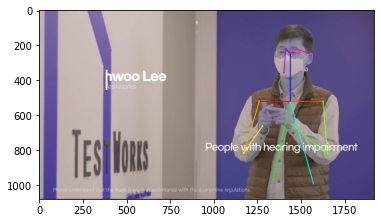

In [ ]:
plt.imshow(image_openpose)

In [ ]:
humans

[BodyPart:0-(0.75, 0.23) score=0.44 BodyPart:1-(0.75, 0.48) score=0.63 BodyPart:2-(0.66, 0.48) score=0.56 BodyPart:3-(0.61, 0.76) score=0.57 BodyPart:4-(0.67, 0.61) score=0.73 BodyPart:5-(0.85, 0.48) score=0.55 BodyPart:6-(0.86, 0.77) score=0.69 BodyPart:7-(0.75, 0.60) score=0.72 BodyPart:8-(0.70, 0.90) score=0.09 BodyPart:11-(0.82, 0.92) score=0.26 BodyPart:14-(0.74, 0.21) score=0.50 BodyPart:15-(0.77, 0.21) score=0.58 BodyPart:16-(0.73, 0.33) score=0.20 BodyPart:17-(0.81, 0.23) score=0.60]

## Pose estimate from a live webcam photo
We can also pass live images from a webcam. This requires a little bit of extra work to work in colab environment because you have to access local webcam through a javascript code in the browser. The same function 'def take_photo' is provided by google Colab. You can insert the code by clicking the code snippet on the left navigation bar of the colab.



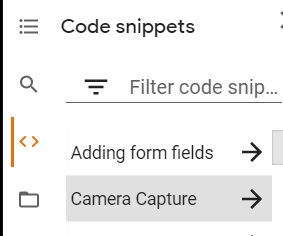

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(imgData, quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

After a picture is taken, you can load it up and pass it to TfPoseEstimator and display the result.

In [ ]:
from IPython.display import Image

try:
  filename = take_photo()
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  image = cv2.imread(filename)
  humans = e.inference(image,
                        resize_to_default=(w > 0 and h > 0),
                        upsample_size=4.0)
  image = TfPoseEstimator.draw_humans(image, humans, imgcopy=False)
  plt.imshow(image)
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

## Pose estimate from a live webcam

To continuous pose estimate from the webcam, still more work is needed. The extra steps are:
1. Take a live image in a bytes array format
2. Convert it into png format
3. Pass the png image to TfPoseEstimator
4. Convert the annotated OpenPose image to bytes array
5. Display the bytes array in the browser through javascript.


The following code is modified from [vindruid's yolov3 example](https://colab.research.google.com/github/vindruid/yolov3-in-colab/blob/master/yolov3_streaming_webcam.ipynb#scrollTo=7OYmjeF-edKE)



In [ ]:
import base64
import html
import io
import time

from IPython.display import display, Javascript
from google.colab.output import eval_js
import numpy as np
from PIL import Image
import cv2

def start_input():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 512, 512);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML =
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 512; //video.videoWidth;
      captureCanvas.height = 512; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }

    async function takePhoto(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();

      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)

def take_live_photo(label, img_data):
  data = eval_js('takePhoto("{}", "{}")'.format(label, img_data))
  return data

In [ ]:
def js_reply_to_image(js_reply):
    """
    input:
          js_reply: JavaScript object, contain image from webcam

    output:
          image_array: image array from webcam
    """
    jpeg_bytes = base64.b64decode(js_reply['img'].split(',')[1])
    image_PIL = Image.open(io.BytesIO(jpeg_bytes))
    return np.asarray(image_PIL)

def image_to_bytes(image_openpose):
    image = Image.fromarray(image_openpose, 'RGB')
    iobuf = io.BytesIO()
    image.save(iobuf, format='png')
    drawing_bytes = 'data:image/png;base64,{}'.format((str(base64.b64encode(iobuf.getvalue()), 'utf-8')))
    return drawing_bytes

In [ ]:
start_input()
label_html = 'Capturing...'
img_data = ''

while True:
    js_reply = take_live_photo(label_html, img_data)
    if not js_reply:
        break

    image = js_reply_to_image(js_reply)

    humans = e.inference(image,
                         resize_to_default=(w > 0 and h > 0),
                         upsample_size=4.0)
    image_openpose = TfPoseEstimator.draw_humans(image, humans, imgcopy=False)

    drawing_bytes = image_to_bytes(image_openpose)
    img_data = drawing_bytes

<IPython.core.display.Javascript object>

# Appendix


## OpenPose json sample
Corresponding each frame is a json file that contains elements for:

- pose_keypoints_2d
- face_keypoints_2d
- hand_keypoints_2d

Each key point is defined as (x, y, confidence).
Below is an example file and a simple visualization of the three key points.

In [ ]:
{
    "version": 1.3,
    "people": [
        {
            "person_id": [
                -1
            ],
            "pose_keypoints_2d": [
                951.139,
                480.116,
                0.851527,
                954.201,
                689.193,
                0.685063,
                718.672,
                674.585,
                0.543361,
                521.41,
                1018.89,
                0.439235,
                809.908,
                912.952,
                0.507798,
                1192.57,
                689.212,
                0.534579,
                1324.98,
                1051.23,
                0.486293,
                1092.5,
                921.709,
                0.488758,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                895.27,
                430.103,
                0.80459,
                1001.23,
                430.119,
                0.859737,
                818.754,
                436.202,
                0.685974,
                1092.46,
                421.395,
                0.646877,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0
            ],
            "face_keypoints_2d": [
                826.538,
                420.695,
                0.664815,
                826.538,
                453.268,
                0.726826,
                827.701,
                483.515,
                0.763742,
                835.844,
                512.598,
                0.830629,
                853.294,
                540.518,
                0.783202,
                873.071,
                560.295,
                0.84458,
                891.684,
                581.234,
                0.759569,
                917.277,
                597.521,
                0.794505,
                947.524,
                606.828,
                0.830592,
                983.587,
                605.664,
                0.764887,
                1011.51,
                587.051,
                0.793389,
                1038.26,
                563.785,
                0.697113,
                1059.2,
                540.518,
                0.702283,
                1076.65,
                506.781,
                0.705468,
                1082.47,
                475.371,
                0.649377,
                1083.63,
                439.308,
                0.589474,
                1080.14,
                406.735,
                0.471469,
                846.314,
                382.305,
                0.517151,
                862.601,
                372.999,
                0.556174,
                881.214,
                366.019,
                0.551965,
                904.481,
                363.692,
                0.532177,
                926.584,
                364.855,
                0.536845,
                981.261,
                384.632,
                0.566445,
                1001.04,
                383.468,
                0.68124,
                1020.81,
                383.468,
                0.691542,
                1040.59,
                383.468,
                0.578028,
                1051.06,
                391.612,
                0.377421,
                946.361,
                411.388,
                0.838859,
                947.524,
                438.145,
                0.907532,
                948.687,
                462.575,
                0.845282,
                951.014,
                487.005,
                0.812557,
                926.584,
                503.291,
                0.921128,
                937.054,
                505.618,
                0.985088,
                952.177,
                511.435,
                0.872653,
                966.137,
                505.618,
                0.908455,
                982.424,
                503.291,
                0.832754,
                871.908,
                428.838,
                0.889709,
                882.378,
                428.838,
                0.918648,
                898.664,
                427.675,
                0.850918,
                910.297,
                428.838,
                0.827413,
                898.664,
                430.002,
                0.970619,
                883.541,
                431.165,
                0.938057,
                987.077,
                425.348,
                0.64753,
                1002.2,
                424.185,
                0.718511,
                1013.83,
                427.675,
                0.619283,
                1021.98,
                428.838,
                0.542805,
                1012.67,
                430.002,
                0.687195,
                1002.2,
                428.838,
                0.782622,
                900.991,
                532.375,
                0.744149,
                920.767,
                531.211,
                0.85551,
                938.217,
                525.395,
                0.861202,
                952.177,
                530.048,
                0.880921,
                964.974,
                525.395,
                0.89781,
                980.097,
                531.211,
                0.845518,
                995.221,
                535.865,
                0.686897,
                977.771,
                549.825,
                0.834523,
                964.974,
                552.151,
                0.854871,
                951.014,
                553.315,
                0.800243,
                938.217,
                550.988,
                0.878431,
                920.767,
                547.498,
                0.793947,
                910.297,
                533.538,
                0.766187,
                938.217,
                537.028,
                0.86602,
                951.014,
                539.355,
                0.841195,
                964.974,
                537.028,
                0.87418,
                988.241,
                537.028,
                0.737325,
                964.974,
                537.028,
                0.863184,
                951.014,
                539.355,
                0.846832,
                938.217,
                537.028,
                0.838925,
                890.521,
                430.002,
                0.92398,
                1008.02,
                427.675,
                0.643618
            ],
            "hand_left_keypoints_2d": [
                905.484,
                941.187,
                0.082329,
                953.564,
                944.015,
                0.0570803,
                911.141,
                837.957,
                0.0877891,
                885.687,
                815.331,
                0.247884,
                874.374,
                816.745,
                0.185516,
                983.26,
                812.503,
                0.179653,
                853.162,
                837.957,
                0.146915,
                840.435,
                829.472,
                0.206812,
                817.809,
                806.847,
                0.289591,
                1035.58,
                813.917,
                0.285373,
                1000.23,
                874.724,
                0.173424,
                802.254,
                861.997,
                0.128384,
                830.536,
                883.209,
                0.117769,
                1063.86,
                825.23,
                0.282017,
                1044.07,
                894.522,
                0.304554,
                786.699,
                876.138,
                0.164715,
                776.8,
                852.098,
                0.169657,
                834.779,
                962.399,
                0.434161,
                796.598,
                963.813,
                0.406121,
                799.426,
                963.813,
                0.431795,
                1068.11,
                918.561,
                0.345921
            ],
            "hand_right_keypoints_2d": [
                942.961,
                912.928,
                0.0497181,
                902.201,
                952.232,
                0.0204189,
                967.708,
                813.94,
                0.0271103,
                854.163,
                848.877,
                0.0483868,
                892.011,
                822.674,
                0.0412984,
                875.999,
                837.231,
                0.0419703,
                827.96,
                885.269,
                0.0688001,
                886.188,
                841.598,
                0.102075,
                886.188,
                815.396,
                0.122211,
                809.036,
                939.13,
                0.0217673,
                897.834,
                891.092,
                0.0473194,
                905.113,
                894.004,
                0.0527376,
                897.834,
                816.851,
                0.0435186,
                1024.48,
                873.624,
                0.0305732,
                1039.04,
                895.459,
                0.0589162,
                996.822,
                898.371,
                0.049467,
                795.935,
                975.523,
                0.0394648,
                1027.39,
                870.712,
                0.0429818,
                1034.67,
                894.004,
                0.0929336,
                1037.58,
                896.915,
                0.0511328,
                1004.1,
                905.649,
                0.0304012
            ],
            "pose_keypoints_3d": [],
            "face_keypoints_3d": [],
            "hand_left_keypoints_3d": [],
            "hand_right_keypoints_3d": []
        }
    ]
}